In [69]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import multiprocessing
import time
import numpy as np
import scipy as sp
import emcee
import sys
import pickle
import TPmod
from scipy import interpolate 
from IPython.display import display
%matplotlib inline

In [70]:
BTprof = np.loadtxt("../Saumon_models/t1600g1000f3.dat",skiprows=1,usecols=(1,2),unpack=True)
print BTprof

[[  3.00000000e-04   6.00000000e-04   8.00000000e-04   9.00000000e-04
    1.20000000e-03   1.50000000e-03   1.90000000e-03   2.40000000e-03
    3.00000000e-03   3.80000000e-03   4.80000000e-03   6.00000000e-03
    7.50000000e-03   9.50000000e-03   1.20000000e-02   1.51000000e-02
    1.89000000e-02   2.39000000e-02   3.00000000e-02   3.78000000e-02
    5.99000000e-02   7.55000000e-02   9.00000000e-02   1.00000000e-01
    1.29600000e-01   1.50600000e-01   1.89600000e-01   2.38700000e-01
    3.00500000e-01   3.78400000e-01   4.76400000e-01   5.99700000e-01
    6.80000000e-01   7.55100000e-01   8.80700000e-01   1.00000000e+00
    1.24760000e+00   1.50690000e+00   1.60030000e+00   1.80440000e+00
    2.00710000e+00   2.38850000e+00   3.00710000e+00   3.78600000e+00
    4.50000000e+00   5.50000000e+00   6.60000000e+00   8.10000000e+00
    1.00000000e+01   1.19758000e+01   1.50775000e+01   1.89826000e+01
    2.38991000e+01   3.00889000e+01   3.78820000e+01   4.46934000e+01
    5.10460000e+01  

In [71]:
logcoarsePress = np.arange(-4.0, 2.5, 0.53)
#logcoarsePress = np.arange(-4.0, 3.0, 0.5)
coarsePress = pow(10,logcoarsePress)
logfinePress = np.arange(-4.0, 2.4, 0.1)
finePress = pow(10,logfinePress)
# forward model wants pressure in mbar
press = finePress
nprof = coarsePress.size
proftype = 2

In [72]:
tfit = sp.interpolate.interp1d(np.log10(BTprof[0]),BTprof[1],bounds_error=False, fill_value="extrapolate")
BTfine = np.asfortranarray(tfit(np.log10(press)),dtype='d')
err_BT = np.ones_like(BTfine)
err_BT[:] = 5.00
print BTfine

[  667.10568173   675.80248948   684.49929724   693.19610499   701.89291274
   710.58972049   719.28652825   727.983336     736.56897846   744.75699146
   760.77713375   771.2977709    784.79247374   798.15606745   810.72559683
   822.11225568   832.44222523   842.93860821   854.13352119   865.44256686
   876.49961081   887.85660842   899.73961166   912.35339236   925.42276866
   939.73296632   955.616566     973.77246462   992.5435932   1013.79739978
  1035.89        1061.5194122   1087.41442375  1116.75795529  1148.59165357
  1183.78652523  1223.66221248  1271.13838768  1326.71909565  1392.33198632
  1467.78        1563.03644348  1662.78019495  1767.07575868  1876.64289777
  1990.19274926  2101.32883452  2191.48479745  2286.97326882  2405.42414538
  2528.86        2652.38026997  2775.77922514  2898.64204165  3021.20362928
  3143.49047377  3265.62522501  3387.86033855  3511.18097585  3636.56042671
  3763.94174074  3891.32305478  4018.70436881  4146.08568284]


In [73]:
def lnlike(theta, press, temp, terr):
    madTP = TPmod.set_prof(proftype,coarsePress,press,theta)
    s2=terr**2
    lnlik = -0.5*np.sum((((BTfine - madTP)**2) / s2) + np.log(2.*np.pi*s2))
    return lnlik
                        

In [74]:
def lnprior(theta,press):
    a1 = theta[0]
    a2 = theta[1]
    P1 = theta[2]
#    P2 = theta[3]
    P3 = theta[3]
    T3 = theta[4]
    if 0. < a1 < 1. and 0. < a2 < 1.0 and T3 > 0.0 and P3 > P1 and P1 > np.log10(press[0]) and P3 < np.log10(press[press.size-1]) and T3 < 10000.:
        return 0.0
    return -np.inf

In [75]:
def lnprob(theta, press, temp, terr):
    lp = lnprior(theta,press)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, press, temp, terr)

In [76]:
ndim, nwalkers = 5, 500
p0 = np.empty([nwalkers,ndim])

In [77]:
p0[:,0] = np.random.rand(nwalkers).reshape(nwalkers)
p0[:,1] = np.random.rand(nwalkers).reshape(nwalkers)
p0[:,2] = -4. + (np.random.rand(nwalkers).reshape(nwalkers) * 5)
#p0[:,3] = p0[:,2] + np.random.rand(nwalkers).reshape(nwalkers) * 50.
p0[:,3] = p0[:,2] + np.random.rand(nwalkers).reshape(nwalkers) *3.
p0[:,4] = np.random.rand(nwalkers).reshape(nwalkers) * 2000.0

In [78]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(press, BTfine, err_BT),threads=4)

In [79]:
start_time = time.time()
sampler.run_mcmc(p0, 30000)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4227.02424192 seconds ---


In [80]:
samples = sampler.chain[:, 20000:, :].reshape((-1, ndim))
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))
print sampler.chain.shape
print("autocorrelation time: {0:.3f}"
                .format(np.mean(sampler.acor)))

Mean acceptance fraction: 0.406
(500, 30000, 5)
autocorrelation time: 91.472


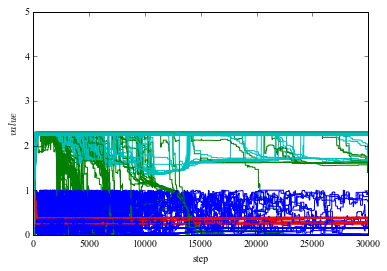

In [81]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0, 30000, 0.,5.])
index = np.arange(30000)
for i in range(0,250):
    plt.plot(index[:],sampler.chain[i,:,0],'r-')
    plt.plot(index[:],sampler.chain[i,:,1],'b-')
    plt.plot(index[:],sampler.chain[i,:,2],'g-')
    plt.plot(index[:],sampler.chain[i,:,3],'c-')
    plt.plot(index[:],sampler.chain[i,:,4],'y-')
#    plt.plot(index[:],sampler.chain[i,:,5],'y-')
    
plt.ylabel(r'$value$')
plt.xlabel('step')


In [82]:
 a1 , a2, P1,P3, T3 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [83]:
print a1
print a2
print P1
#print P2
print P3
print T3

(0.38377948083190355, 0.0019650602358185498, 0.0022004373145743661)
(0.14268190081674526, 0.00045445456673218199, 0.00047667818065155743)
(-1.384777981670982, 0.011199233344706183, 0.0097169074214666917)
(2.2469414272561488, 0.0074484743006713039, 0.0074967204502760509)
(4386.9980934483929, 8.3690230443589826, 9.1996772167149174)


In [84]:
test= [a1[0],a2[0],P1[0], P3[0],T3[0]]
madprof =  TPmod.set_prof(proftype,coarsePress,press,test)
print test

[0.38377948083190355, 0.14268190081674526, -1.384777981670982, 2.2469414272561488, 4386.9980934483929]


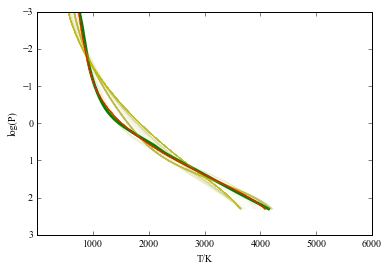

In [85]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([5., 6000.,3.0,-3.0])
#plt.plot(outspec[0,:],(outspec[1,:] / B),'r-')
#plt.plot(outspec[0,:],B,'b-')
#plt.fill_between(T[:,1],T[:,2], logP,facecolor='red',interpolate=True)
#plt.plot(T[:,1],logP,'r--')
#plt.plot(T[:,2],logP,'r--')
logP = np.log10(press)
plt.plot(BTfine,logP,'g-',linewidth=3)
sampT = np.ones_like(test)
for sampT[:] in samples[(np.random.randint(len(samples[:,:]), size=5000)),:]:
    plotT = TPmod.set_prof(proftype,coarsePress,press,sampT)
    plt.plot(plotT,logP, color="y", alpha=0.02)

plt.plot(madprof,logP,'r-')

plt.ylabel(r'log(P)')
plt.xlabel('T/K')

#as

In [86]:
print madprof

[  710.33547177   711.96077918   714.00291783   716.51655389   719.55219095
   723.1546754    727.36228387   732.20603308   737.71027111   743.89301475
   750.76651603   758.3377845    766.60885256   775.57667277   785.23264361
   795.56191177   806.54279098   818.14684694   830.34037562   843.08807056
   856.35954915   870.13902306   884.43775138   899.30812379   914.85742607
   931.25882676   948.75713045   967.66743051   988.36593248  1011.27365304
  1036.83506603  1065.49470363  1097.67498817  1133.75812842  1174.07392714
  1218.89411381  1268.43266341  1322.85073859  1382.26451366  1446.75417889
  1516.37275969  1591.15385712  1671.11788202  1756.27401665  1846.62320415
  1942.15943962  2042.86572694  2148.70744908  2259.62098911  2375.49523826
  2496.14588725  2621.28061626  2750.45614218  2883.03031849  3018.1155152
  3154.54264955  3290.84739738  3425.29010957  3555.91784451  3680.6704863
  3797.52401054  3904.65455206  4000.59965517  4084.39042278]


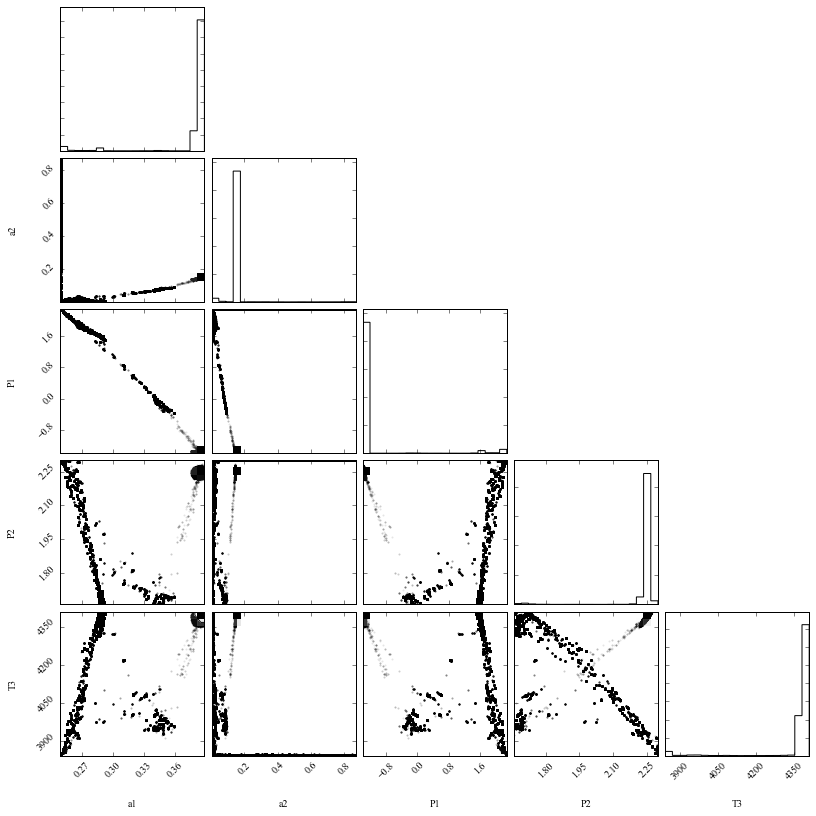

In [87]:
import corner
fig = corner.corner(samples, labels=["a1", "a2", "P1","P2","T3"],range=[0.99,0.99,0.99,0.99,0.99])